In [1]:
# import jax.numpy as np
# import numpy as tnp
from prysm.mathops import np,fft
import matplotlib.pyplot as plt
import prysm
prysm.__version__

'0.19.2.dev422+gfb77e89'

In [2]:
# SIMULATION PARAMETERS
EFL = 131.4e3 # milimeters
EPD = 6.510e3 # milimeters
WVL = 0.656   # microns
OS = 6
IMG_NPIX = 1024

# Dark Hole
IWA = 3
OWA = 7
AZMIN = -60
AZMAX = 60

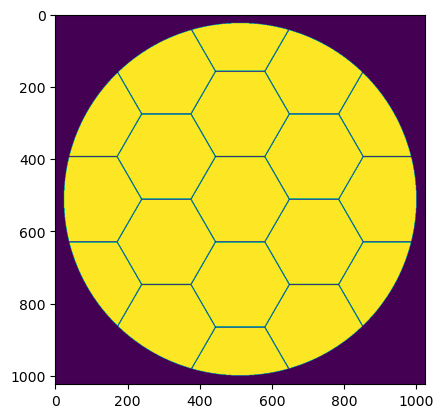

In [3]:
from astropy.io import fits

# Load Aperture
circle_mask = fits.getdata('/Users/jashcraft/Downloads/hex_pupil_amplitude_6510mm_1024pix.fits')
plt.imshow(circle_mask)
PUPIL_NPIX = circle_mask.shape[0]

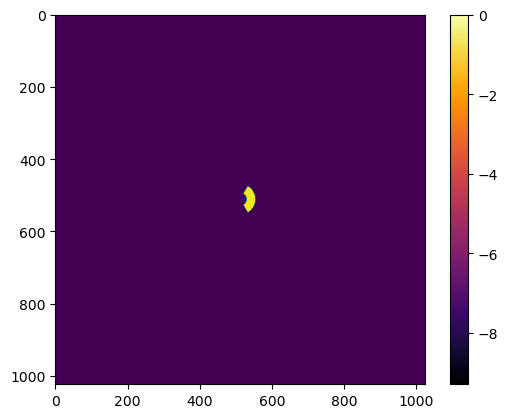

In [4]:
from prysm.propagation import focus_fixed_sampling,focus_fixed_sampling_backprop
from prysm import coordinates, geometry

img_dx = WVL * (EFL / EPD) / OS
pupil_dx = EPD / PUPIL_NPIX
# now set up the focal plane mask
psf = focus_fixed_sampling(wavefunction=circle_mask,
                           input_dx=pupil_dx,
                           prop_dist=EFL,
                           wavelength=WVL,
                           output_dx=img_dx,
                           output_samples=IMG_NPIX)

from dygdug.models import ImgSamplingSpec, one_sided_annulus

lambd = EFL / EPD * WVL  # um
iss = ImgSamplingSpec(IMG_NPIX, lambd / OS, lambd)  # 10/lambd
dh = one_sided_annulus(iss, IWA,
                            OWA, 
                            AZMIN,
                            AZMAX)
psf_I = np.abs(psf)**2
plt.imshow(dh * np.log10(psf_I/psf_I.max()+1e-16),cmap='inferno')
plt.colorbar()

# create the core mask
def inner_core_mask(iss, iwa):

    x, y = coordinates.make_xy_grid(iss.N, dx=iss.dx)
    r, t = coordinates.cart_to_polar(x, y)
    iwa = iwa * iss.lamD
    mask = geometry.circle(iwa, r)

    return mask

def knife_edge_mask(iss, iwa):
    x, y = coordinates.make_xy_grid(iss.N, dx=iss.dx)
    iwa = iwa * iss.lamD
    mask = x > iwa

    return mask

def lyot_mask(pupil_npix, pupil_dx, frac):

    x, y = coordinates.make_xy_grid(pupil_npix, dx=pupil_dx)
    r, t = coordinates.cart_to_polar(x, y)
    rnorm = r / (r.max() * np.sqrt(2))
    ls = np.zeros_like(x)
    ls[rnorm < frac/2] = 1

    return ls


# mask transmits inner 1.5 L/D
inner_mask = inner_core_mask(iss, 1.5)
knife_mask = knife_edge_mask(iss, IWA)
ls_mask = lyot_mask(circle_mask.shape[0], pupil_dx=pupil_dx, frac=0.85)
plt.imshow(dh)

In [5]:
from dygdug.vappid import APLCOptimizer2

aplc = APLCOptimizer2(amp=circle_mask,
                      amp_dx=pupil_dx,
                      efl=EFL, 
                      wvl=WVL, 
                      basis=None, 
                      dark_hole=dh,
                      dh_target=1e-15,
                      dh_dx=img_dx,
                      fpm=knife_mask,
                      ls=ls_mask)

aplc.set_optimization_method(zonal=True)
print(aplc.zonal)
aplc.fwd(np.random.random(aplc.amp[aplc.amp_select].shape))
aplc.rev(np.random.random(aplc.amp[aplc.amp_select].shape))

True


array([-1.06075051e-08, -1.17704788e-08, -1.25499023e-08, ...,
       -1.67464433e-08, -1.59766650e-08, -1.49936386e-08])

In [6]:
from prysm.x.optym import F77LBFGSB

x0 = np.ones(aplc.amp.shape, dtype=float)[aplc.amp_select]
x0 = np.ascontiguousarray(x0)
opt = F77LBFGSB(aplc.fg, x0, memory=10, upper_bounds=np.ones(x0.shape), lower_bounds=np.zeros(x0.shape))
opt.iprint = 0

for _ in range(100):
    opt.step()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       732197     M =           10


/var/folders/xs/d1q2b9xj0j35ml7lb2vmfb240000gn/T/ipykernel_1304/4073835253.py:4: RuntimeWarning: invalid value encountered in divide
  plt.imshow(np.imag(aplc.bbar * aplc.b.conj())/aplc.amp,cmap='RdBu_r')


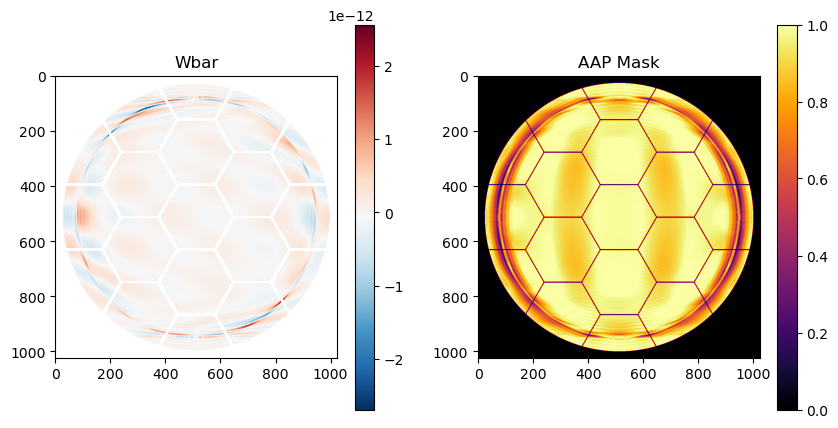

In [7]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('Wbar')
plt.imshow(np.imag(aplc.bbar * aplc.b.conj())/aplc.amp,cmap='RdBu_r')
plt.colorbar()
plt.subplot(122)
plt.title('AAP Mask')
plt.imshow(aplc.aap,cmap='inferno') 
plt.colorbar()
plt.show()

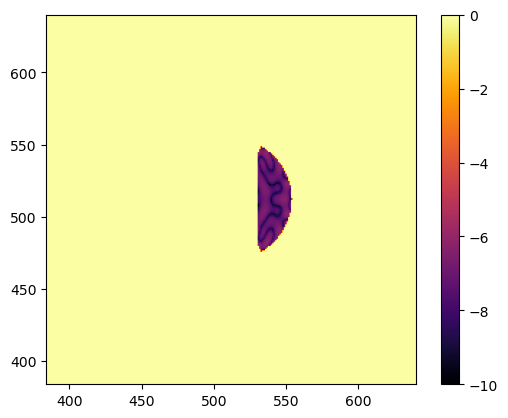

In [9]:
cut = 128
plt.imshow(np.log10(aplc.I/aplc.I.max()) * aplc.fpm * aplc.dh,cmap='inferno',vmin=-10)
plt.xlim(IMG_NPIX/2 - cut, IMG_NPIX/2 + cut)
plt.ylim(IMG_NPIX/2 - cut, IMG_NPIX/2 + cut)
plt.colorbar()